# Utilities

## Notes

Data taken from http://www.naturalstattrick.com/

* Add bio information about players (position, team, for example) DONE
* Add PTS/$ (probably in excel directly)
* Reorder columns (based on excel)

In [56]:
import pandas as pd
import numpy as np
import re
import math
import pickle
import glob
import xgboost
import tsfresh
import os
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from pprint import pprint
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score, log_loss
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_context('notebook')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 100, 'linewidths':0}
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.options.mode.chained_assignment = None  # default='warn'

In [57]:
# Paths
data_folder = '../data/'

---
# Read datasets

In [58]:
def read_dataset(file_paths_regex):
    data_paths = glob.glob(file_paths_regex)
    data_paths.sort()
    
    data = pd.DataFrame()
    for file_path in data_paths:
        file = pd.read_csv(file_path, sep=',', encoding="utf-8-sig")
        file['Year'] = '20' + file_path.split('-')[2]
        file = file.rename(columns={'Unnamed: 0': 'Index'}).set_index('Index')
        data = pd.concat([data, file], sort=False)
    data['Name'] = data.apply(lambda player: re.sub(r'\W+', '', f'{player["Player"]})').upper(), axis=1)
    data.set_index('Name', inplace=True)
    return data

In [59]:
# # Read the 3 kinds of datasets
# individuals = read_dataset('./nhl-stats_rates/*ind.csv')
# on_ice = read_dataset('./nhl-stats_rates/*ice.csv')
# on_ice.drop(['GP', 'TOI'], axis=1, inplace=True) # Because already in individuals
# biography = read_dataset('./nhl-stats_rates/*bio.csv')

# Read the 3 kinds of datasets
individuals = read_dataset(os.path.join(data_folder, 'nhl-stats_rates/*ind-rates.csv'))
on_ice = read_dataset(os.path.join(data_folder, './nhl-stats_rates/*ice-rates.csv'))
on_ice.drop(['GP', 'TOI'], axis=1, inplace=True) # Because already in individuals
on_ice_pp = read_dataset(os.path.join(data_folder, './nhl-stats_rates/*ind-pp.csv'))
on_ice_pp.drop(['GP'], axis=1, inplace=True) # Because already in individuals
new_cols = ['_'.join([col, 'PP']) for col in on_ice_pp.columns[3:]]
new_cols = ['Player', 'Team', 'Position'] + new_cols
new_cols[-1] = 'Year'
on_ice_pp.columns = new_cols
biography = read_dataset(os.path.join(data_folder, './nhl-stats_rates/*bio.csv'))

# Merge the 3 datasets together
tmp = pd.merge(biography, individuals, on=['Player', 'Team', 'Position', 'Year'])
tmp = pd.merge(tmp, on_ice, on=['Player', 'Team', 'Position', 'Year'])
nhl_players = pd.merge(tmp, on_ice_pp, on=['Player', 'Team', 'Position', 'Year'])

# List of columns
cols = list(nhl_players)
                                    
# Move the column to head of list using index, pop and insert Year first
cols.insert(0, cols.pop(cols.index('Year')))

# Reorder
nhl_players = nhl_players.loc[:, cols]
nhl_players = nhl_players.sort_values(['Player', 'Year'])

nhl_players.head(10)

,Year,Player,Team,Position,Age,Date of Birth,Birth City,Birth State/Province,Birth Country,Nationality,Height (in),Weight (lbs),Draft Year,Draft Team,Draft Round,Round Pick,Overall Draft Position,GP,TOI,TOI/GP_x,Goals/60,Total Assists/60,First Assists/60,Second Assists/60,Total Points/60,IPP,Shots/60,SH%,iCF/60,iFF/60,iSCF/60,iHDCF/60,Rush Attempts/60,Rebounds Created/60,PIM/60,Total Penalties/60,Minor/60,Major/60,Misconduct/60,Penalties Drawn/60,Giveaways/60,Takeaways/60,Hits/60,Hits Taken/60,Shots Blocked/60,Faceoffs Won/60,Faceoffs Lost/60,Faceoffs %,ixG/60,TOI/GP_y,CF/60,CA/60,CF%,FF/60,FA/60,FF%,SF/60,SA/60,SF%,GF/60,GA/60,GF%,SCF/60,SCA/60,SCF%,HDCF/60,HDCA/60,HDCF%,HDGF/60,HDGA/60,HDGF%,MDCF/60,MDCA/60,MDCF%,MDGF/60,MDGA/60,MDGF%,LDCF/60,LDCA/60,LDCF%,LDGF/60,LDGA/60,LDGF%,On-Ice SH%,On-Ice SV%,PDO,Off. Zone Starts/60,Neu. Zone Starts/60,Def. Zone Starts/60,On The Fly Starts/60,Off. Zone Start %,Off. Zone Faceoffs/60,Neu. Zone Faceoffs/60,Def. Zone Faceoffs/60,Off. Zone Faceoff %,xGF/60,xGA/60,xGF%,TOI_PP,Goals_PP,Total Assists_PP,First Assists_PP,Second Assists_PP,Total Points_PP,IPP_PP,Shots_PP,SH%_PP,ixG_PP,iCF_PP,iFF_PP,iSCF_PP,iHDCF_PP,Rush Attempts_PP,Rebounds Created_PP,PIM_PP,Total Penalties_PP,Minor_PP,Major_PP,Misconduct_PP,Penalties Drawn_PP,Giveaways_PP,Takeaways_PP,Hits_PP,Hits Taken_PP,Shots Blocked_PP,Faceoffs Won_PP,Faceoffs Lost_PP,Faceoffs %_PP
0,2018,Aaron Ekblad,FLA,D,23,1996-02-07,Windsor,ON,CAN,CAN,76,220,2014,FLA,1,1,1,82,1938.816667,23.644106,0.40,0.74,0.25,0.50,1.15,32.74,5.57,7.22,9.75,7.12,2.82,0.68,0.31,0.93,1.45,0.68,0.65,0.03,0.00,0.50,3.78,1.45,3.53,3.56,2.72,0.00,0.00,-,0.28,23.644106,56.17,57.47,49.43,44.13,44.10,50.02,33.58,31.01,51.99,3.50,3.68,48.71,25.53,27.79,47.88,11.11,12.69,46.68,2.01,2.20,47.79,19.23,20.14,48.85,1.36,1.28,51.56,36.21,35.36,50.59,0.63,0.63,50.00,10.41,88.12,0.985,8.39,13.96,12.53,41.10,40.09,19.40,21.32,24.76,43.94,2.75,3.01,47.69,138.800000,5,5,2,3,10,58.82,37,13.51,3.10,57,43,15,3,1,7,5,1,0,1,0,1,8,0,3,4,0,0,0,-
1,2018,Adam Clendening,CBJ,D,26,1992-10-26,Niagara Falls,NY,USA,USA,72,196,2011,CHI,2,6,36,4,42.616667,10.654167,0.00,0.00,0.00,0.00,0.00,0.00,4.22,0.00,11.26,4.22,1.41,0.00,1.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.82,1.41,12.67,4.22,0.00,0.00,-,0.10,10.654167,47.87,73.21,39.53,33.79,59.13,36.36,26.75,45.05,37.25,2.82,2.82,50.00,19.71,40.83,32.56,5.63,15.49,26.67,0.00,1.41,0.00,18.77,33.79,35.71,1.88,1.88,50.00,30.50,40.67,42.86,2.03,0.00,100.00,10.53,93.75,1.043,12.67,14.08,8.45,54.91,60.00,18.30,18.30,15.49,54.17,1.80,3.76,32.42,1.150000,0,0,0,0,0,-,0,-,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-
2,2018,Adam Erne,T.B,L,24,1995-04-20,New Haven,CT,USA,USA,73,214,2013,T.B,2,3,33,65,685.633333,10.548205,0.61,1.14,0.53,0.61,1.75,58.82,6.13,10.00,11.81,9.01,7.26,3.24,0.70,0.70,3.50,1.14,0.88,0.18,0.09,1.05,0.70,1.40,13.91,4.81,2.28,0.96,1.05,4.19,0.57,10.548205,50.41,53.21,48.65,38.33,40.87,48.4,27.57,28.97,48.76,2.98,1.84,61.82,25.55,23.98,51.59,10.85,8.75,55.36,1.40,1.05,57.14,19.60,20.30,49.12,1.52,0.70,68.42,31.60,37.16,45.96,0.63,0.38,62.50,10.79,93.66,1.044,8.58,16.63,9.28,50.67,48.04,13.91,22.32,17.24,44.66,2.20,2.02,52.04,32.383333,2,0,0,0,2,50.00,7,28.57,0.60,8,7,5,2,0,0,12,3,1,2,0,0,0,0,1,1,0,0,0,-
3,2018,Adam Gaudette,VAN,C,22,1996-10-03,Braintree,MA,USA,USA,73,170,2015,VAN,5,28,149,56,613.150000,10.949107,0.49,0.68,0.39,0.29,1.17,50.00,5.38,9.09,10.76,8.12,6.26,2.35,0.20,0.98,1.76,0.78,0.78,0.00,0.00,1.37,0.68,0.98,4.70,5.38,1.47,14.68,21.63,3.96,0.54,10.949107,54.80,52.65,51,40.81,39.83,50.61,29.26,30.14,49.26,2.35,2.45,48.98,23.29,27.01,46.3,7.24,10.86,40,0.98,1.37,41.67,21.40,21.53,49.85,1.17,1.04,52.94,38.45,30.53,55.74,0.71,0.42,62.50,8.03,91.88,0.999,14.58,12.62,4.21,56.36,77.60,19.57,17.22,10.37,65.36,1.96,2.22,46.89,76.633333,0,2,1,1,2,28.57,9,0.00,1.34,18,16,12,5,0,1,0,0,0,0,0,0,1,0,0,5,0,12,13,48.00
4,2018,Adam Henrique,ANA,C,29,1990-02-06,Brantford,ON,CAN,CAN,72,197,2008,N.J,3,21,82,82,1349.000000,16.451220,0.80,1.07,0.67,0.40,

---
# Preprocessing

Outliers
The outliers in your dataset are a mixed bag. One the one hand, they may contain key information since they are so different from the main group. On the other hand they throw off our view of the main group since we have to look so far out just to see the outliers! On the ML side of things, training with outliers included may allow your model to generalise well but also throw it off from the main group where most of your data is.

In general, it’s usually recommended to look at both sides. Explore your data both with and without outliers. If you decide that you need them for your ML model then select a method that will be robust enough to handle them. If you find that those outliers are really out there and not useful for getting the big picture information and modelling of your data, then it’s best to just drop them as shown in the last section.

In addition, if you want to filter out those outliers you can use the following method:

```
# Get the 98th and 2nd percentile as the limits of our outliers
upper_limit = np.percentile(train_df.logerror.values, 98) 
lower_limit = np.percentile(train_df.logerror.values, 2) 
# Filter the outliers from the dataframe
data[‘target’].loc[train_df[‘target’]>upper_limit] = upper_limit data[‘target’].loc[train_df[‘target’]<lower_limit] = lower_limit
```

## Utilities

In [60]:
def get_draft_year(player):
    if player['Draft Year'] == '-':
        return int(player['Date of Birth'].split('-')[0]) + 18
    else:
        return player['Draft Year']
    
def get_draft_position(player):
    if player['Overall Draft Position'] == '-':
        return 0
    else:
        return player['Overall Draft Position']   

## Clean Data

In [61]:
# Fix column names
# There is some weird characters for some column names
cols = nhl_players.columns
cols = cols.map(lambda x: x.replace(u'\xa0', u' ') if isinstance(x, (str)) else x)
nhl_players.columns = cols

In [62]:
# Remove incomplete instances
# Remove instance if a players has played less than 10GP in a season
# nhl_players = nhl_players[nhl_players.GP > 10]

# Remove players with 1 season played
# nhl_players = nhl_players[nhl_players.groupby('Player')['Year'].transform(len) > 1]

In [63]:
# Fill missing data
# Age infered based on birth year and current year of season played
nhl_players['Date of Birth'] = nhl_players['Date of Birth'].replace({'-': '2000-01-01'})
nhl_players['Age'] = nhl_players.apply(lambda plyr: int(plyr['Year'])-int(plyr['Date of Birth'].split('-')[0]), axis=1)

# If not draft year, infered based on date of birth + 18 years
nhl_players['Draft Year'] = nhl_players.apply(lambda plyr: get_draft_year(plyr), axis=1)

# If no overall draft position, we return 0
nhl_players['Overall Draft Position'] = nhl_players.apply(lambda plyr: get_draft_position(plyr), axis=1)

# Real total points
nhl_players['Total Points'] = (nhl_players['Total Points/60'] * nhl_players['TOI'] / 60).astype(int)

# # If no value is given for a particular stat, we insert the mean of that stat
# for col in ['GP', 'TOI', 'Goals', 'Total Assists', 'First Assists', 'Second Assists', 'Total Points', 
#             'IPP', 'Shots', 'SH%', 'iCF', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'Rebounds Created', 
#             'PIM', 'Total Penalties', 'Minor', 'Major', 'Misconduct', 'Penalties Drawn', 'Giveaways', 
#             'Takeaways', 'Hits', 'Hits Taken', 'Shots Blocked', 'Faceoffs Won', 'Faceoffs Lost', 
#             'Faceoffs %', 'CF', 'CA', 'CF%', 'FF', 'FA', 'FF%', 'SF', 'SA', 'SF%', 'GF', 'GA', 'GF%', 
#             'SCF', 'SCA', 'SCF%', 'HDCF', 'HDCA', 'HDCF%', 'HDGF', 'HDGA', 'HDGF%', 'MDCF', 'MDCA', 
#             'MDCF%', 'MDGF', 'MDGA', 'MDGF%', 'LDCF', 'LDCA', 'LDCF%', 'LDGF', 'LDGA', 'LDGF%', 
#             'On-Ice SH%', 'On-Ice SV%', 'PDO', 'Off. Zone Starts',
#             'Neu. Zone Starts', 'Def. Zone Starts', 'On The Fly Starts',
#             'Off. Zone Start %', 'Off. Zone Faceoffs', 'Neu. Zone Faceoffs',
#             'Def. Zone Faceoffs', 'Off. Zone Faceoff %']:
# If no value is given for a particular stat, we insert the mean of that stat
for col in ['GP', 'TOI', 'Goals/60', 'Total Assists/60', 'First Assists/60', 'Second Assists/60', 'Total Points/60', 
            'IPP', 'Shots/60', 'SH%', 'iCF/60', 'iFF/60', 'iSCF/60', 'iHDCF/60', 'Rush Attempts/60', 'Rebounds Created/60', 
            'PIM/60', 'Total Penalties/60', 'Minor/60', 'Major/60', 'Misconduct/60', 'Penalties Drawn/60', 'Giveaways/60', 
            'Takeaways/60', 'Hits/60', 'Hits Taken/60', 'Shots Blocked/60', 'Faceoffs Won/60', 'Faceoffs Lost/60', 
            'Faceoffs %', 'CF/60', 'CA/60', 'CF%', 'FF/60', 'FA/60', 'FF%', 'SF/60', 'SA/60', 'SF%', 'GF/60', 'GA/60', 'GF%', 
            'SCF/60', 'SCA/60', 'SCF%', 'HDCF/60', 'HDCA/60', 'HDCF%', 'HDGF/60', 'HDGA/60', 'HDGF%', 'MDCF/60', 'MDCA/60', 
            'MDCF%', 'MDGF/60', 'MDGA/60', 'MDGF%', 'LDCF/60', 'LDCA/60', 'LDCF%', 'LDGF/60', 'LDGA/60', 'LDGF%', 
            'On-Ice SH%', 'On-Ice SV%', 'PDO', 'Off. Zone Starts/60',
            'Neu. Zone Starts/60', 'Def. Zone Starts/60', 'On The Fly Starts/60',
            'Off. Zone Start %', 'Off. Zone Faceoffs/60', 'Neu. Zone Faceoffs/60',
            'Def. Zone Faceoffs/60', 'Off. Zone Faceoff %']:
    mean = nhl_players[~nhl_players[col].isin(['-'])][col].astype(float).mean()
    nhl_players[col].replace('-', 0, inplace=True)
    
for col in ['TOI_PP', 'Goals_PP', 'Total Assists_PP', 'First Assists_PP', 'Second Assists_PP', 'Total Points_PP', 
            'IPP_PP', 'Shots_PP', 'SH%_PP', 'iCF_PP', 'iFF_PP', 'iSCF_PP', 'iHDCF_PP', 'Rush Attempts_PP', 
            'Rebounds Created_PP', 'PIM_PP', 'Total Penalties_PP', 'Minor_PP', 'Major_PP', 'Misconduct_PP', 'Penalties Drawn_PP', 
            'Giveaways_PP', 'Takeaways_PP', 'Hits_PP', 'Hits Taken_PP', 'Shots Blocked_PP', 'Faceoffs Won_PP', 'Faceoffs Lost_PP', 
            'Faceoffs %_PP']:
    mean = nhl_players[~nhl_players[col].isin(['-'])][col].astype(float).mean()
    nhl_players[col].replace('-', 0, inplace=True)
    
# To numeric
nhl_players[nhl_players.columns[16:]] = nhl_players[nhl_players.columns[16:]].apply(pd.to_numeric)
nhl_players.Year = nhl_players.Year.apply(pd.to_numeric)

In [64]:
# %%time
# # Add synthetic seasons to players with less than 3 seasons played
# all_players = nhl_players.Player.unique()
# means = nhl_players.describe().loc['mean']
# for player in all_players:
#     player_stats = nhl_players[nhl_players.Player == player]
#     nb_of_years_played = player_stats.shape[0]
#     if nb_of_years_played < 4:
#         nb_seasons_to_add = 4 - nb_of_years_played
#         for i in range(0, nb_seasons_to_add):
#             synthetic_season = means
#             synthetic_season['Player'] = player_stats.Player.unique()[0]
#             synthetic_season['Year'] = player_stats.Year.astype(int).min() - (i+1)
#             synthetic_season['Age'] = player_stats.Age.astype(int).min()
#             synthetic_season['Overall Draft Position'] = player_stats['Overall Draft Position'].unique()[0]
#             nhl_players = nhl_players.append(synthetic_season, ignore_index=True)

## Split target values

In [65]:
# Rework to get the points from the last season played of all player, and divide by games played, this is the target value
# And remove the features from this last season (so the lines of this player for his last season)

# Get target value (pts/gp in 2017)
# Sort and get pts/gp
nhl_players.sort_values(['Player', 'Year'], inplace=True)
nhl_players['PTS_expected'] = round(82*(nhl_players['Total Points']/nhl_players['GP']))

# Select the last season played by each player
total_points_df = nhl_players.groupby('Player').tail(1)
total_points_df_sub = total_points_df[['Player', 'PTS_expected']].set_index('Player')
total_points = total_points_df_sub['PTS_expected']

# Remove target value instances
# nhl_players = pd.merge(nhl_players, total_points_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

# Keep only the last 3 seasons of each players, to take into account their current pace and not their entire career pace
# eg: Chara is doing less points at 39 than 25
nhl_players = nhl_players.groupby('Player').tail(5)

## Remove unecessary features

In [66]:
# Split features
# Keep in memory the player and year order
nhl_players_features_player = nhl_players['Player']
nhl_players_features_year = nhl_players['Year']

# # Drop unecessary columns
# nhl_players_features = nhl_players.drop([#'Year', 'Player', 
#                                          'Team', 'Position', 'Draft Year', 'Date of Birth', 
#                                          'Birth City', 'Birth State/Province', 'Birth Country', 
#                                          'Nationality', 'Height (in)', 'Weight (lbs)', 
#                                          'Draft Team', 'Draft Round', 'Round Pick', 'IPP', 'Overall Draft Position',
#                                          'PIM', 'Total Penalties', 'Minor', 'Major', 'Misconduct',
#                                          'Hits', 'Hits Taken', 'Shots Blocked',
#                                          'Goals', 'Total Assists', 'First Assists', 'Second Assists',
#                                          'Rush Attempts', 'Rebounds Created', 'Penalties Drawn', 'Giveaways',
#                                          'Takeaways', 'Faceoffs Won', 'Faceoffs Lost', 'Faceoffs %',
#                                          'Off. Zone Starts', 'Neu. Zone Starts', 'Def. Zone Starts', 
#                                          'On The Fly Starts', 'Off. Zone Faceoffs', 'Neu. Zone Faceoffs', 'Def. Zone Faceoffs',
#                                          'CA', 'FA', 'SA', 'GA', 'SCA', 'HDCA', 'HDGA', 'MDCA', 'MDGA', 'LDCA', 'LDGA', 'SH%,' 'On-Ice SV%',
#                                          'iCF', 'iFF', 'iSCF', 'iHDCF', 'CF', 'FF', 'SF', 'GF', 'SCF', 'HDCF', 'HDGF', 'MDCF', 'MDGF', 'LDCF', 'LDGF',
#                                          'Total Points', 
#                                          'HDCF%', 'HDGF%', 'MDCF%', 'MDGF%', 'LDCF%', 'LDGF%'], axis=1)
# Drop unecessary columns
nhl_players_features = nhl_players.drop([#'Year', 'Player', 
                                         'Team', 'Position', 'Draft Year', 'Date of Birth', 
                                         'Birth City', 'Birth State/Province', 'Birth Country', 
                                         'Nationality', 'Height (in)', 'Weight (lbs)', 
                                         'Draft Team', 'Draft Round', 'Round Pick', 'IPP', 'Overall Draft Position',
                                         'PIM/60', 'Total Penalties/60', 'Minor/60', 'Major/60', 'Misconduct/60',
                                         'Hits/60', 'Hits Taken/60', 'Shots Blocked/60',
                                         'Goals/60', 'Total Assists/60', 'First Assists/60', 'Second Assists/60',
                                         'Goals_PP', 'Total Assists_PP', 'First Assists_PP', 'Second Assists_PP',
                                         'Rush Attempts/60', 'Rebounds Created/60', 'Penalties Drawn/60', 'Giveaways/60',
                                         'Rush Attempts_PP', 'Rebounds Created_PP', 'PIM_PP', 'Total Penalties_PP', 'Minor_PP', 'Major_PP', 'Misconduct_PP', 'Penalties Drawn_PP',
                                         'Takeaways/60', 'Faceoffs Won/60', 'Faceoffs Lost/60', 'Faceoffs %', 'TOI/GP_y',
                                         'Neu. Zone Starts/60', 'Def. Zone Starts/60', 
                                         'On The Fly Starts/60', 'Neu. Zone Faceoffs/60', 'Def. Zone Faceoffs/60',
                                         'Giveaways_PP', 'Takeaways_PP', 'Hits_PP', 'Hits Taken_PP', 'Shots Blocked_PP', 
                                         'Faceoffs Won_PP', 'Faceoffs Lost_PP', 'Faceoffs %_PP',
                                         'CA/60', 'FA/60', 'SA/60', 'GA/60', 'SCA/60', 'HDCA/60', 'HDGA/60', 'MDCA/60', 'MDGA/60', 'LDCA/60', 'LDGA/60', 'SH%', 'On-Ice SV%',
                                         'HDCF/60', 'HDGF/60', 'MDCF/60', 'MDGF/60', 'LDCF/60', 'LDGF/60',
                                         'Total Points', 
                                         'HDCF%', 'HDGF%', 'MDCF%', 'MDGF%', 'LDCF%', 'LDGF%'], axis=1)

# Sort Values
nhl_players_features = nhl_players_features.fillna(0)
nhl_players_features.sort_values(['Player', 'Year'], inplace=True)

In [67]:
nhl_players_features.head(10)

,Year,Player,Age,GP,TOI,TOI/GP_x,Total Points/60,Shots/60,iCF/60,iFF/60,iSCF/60,iHDCF/60,ixG/60,CF/60,CF%,FF/60,FF%,SF/60,SF%,GF/60,GF%,SCF/60,SCF%,On-Ice SH%,PDO,Off. Zone Starts/60,Off. Zone Start %,Off. Zone Faceoffs/60,Off. Zone Faceoff %,xGF/60,xGA/60,xGF%,TOI_PP,Total Points_PP,IPP_PP,Shots_PP,SH%_PP,ixG_PP,iCF_PP,iFF_PP,iSCF_PP,iHDCF_PP,PTS_expected
0,2018,Aaron Ekblad,22,82,1938.816667,23.644106,1.15,5.57,9.75,7.12,2.82,0.68,0.28,56.17,49.43,44.13,50.02,33.58,51.99,3.50,48.71,25.53,47.88,10.41,0.985,8.39,40.09,19.40,43.94,2.75,3.01,47.69,138.800000,10,58.82,37,13.51,3.10,57,43,15,3,37.0
1,2018,Adam Clendening,26,4,42.616667,10.654167,0.00,4.22,11.26,4.22,1.41,0.00,0.10,47.87,39.53,33.79,36.36,26.75,37.25,2.82,50.00,19.71,32.56,10.53,1.043,12.67,60.00,18.30,54.17,1.80,3.76,32.42,1.150000,0,0.00,0,0.00,0.00,1,0,0,0,0.0
2,2018,Adam Erne,23,65,685.633333,10.548205,1.75,6.13,11.81,9.01,7.26,3.24,0.57,50.41,48.65,38.33,48.40,27.57,48.76,2.98,61.82,25.55,51.59,10.79,1.044,8.58,48.04,13.91,44.66,2.20,2.02,52.04,32.383333,2,50.00,7,28.57,0.60,8,7,5,2,24.0
3,2018,Adam Gaudette,22,56,613.150000,10.949107,1.17,5.38,10.76,8.12,6.26,2.35,0.54,54.80,51.00,40.81,50.61,29.26,49.26,2.35,48.98,23.29,46.30,8.03,0.999,14.58,77.60,19.57,65.36,1.96,2.22,46.89,76.633333,2,28.57,9,0.00,1.34,18,16,12,5,16.0
4,2018,Adam Henrique,28,82,1349.000000,16.451220,1.87,5.43,9.96,8.45,6.67,3.91,0.71,55.51,49.60,41.85,49.66,28.55,49.35,3.02,53.13,27.22,50.79,10.59,1.015,14.90,58.06,23.26,54.48,2.83,2.78,50.38,189.366667,13,56.52,29,27.59,5.02,53,44,38,24,42.0
5,2018,Adam Larsson,26,82,1773.100000,21.623171,0.68,3.96,8.26,5.75,1.79,0.17,0.13,50.83,46.50,38.07,45.99,27.54,45.42,1.83,33.54,23.32,45.51,6.63,0.957,5.82,29.91,16.65,40.43,2.21,2.82,43.97,6.333333,0,0.00,3,0.00,0.07,3,3,0,0,20.0
6,2018,Adam Lowry,25,78,1141.783333,14.638248,1.21,5.52,9.35,7.67,5.78,3.52,0.64,49.61,43.95,36.47,44.12,25.91,43.98,2.00,43.68,20.60,43.17,7.71,0.999,7.57,30.51,13.56,32.13,2.06,2.82,42.20,8.316667,0,0.00,0,0.00,0.00,0,0,0,0,24.0
7,2018,Adam McQuaid,32,50,788.866667,15.777333,0.53,2.13,5.55,3.80,0.99,0.00,0.12,41.68,40.00,31.56,40.49,22.89,41.12,2.28,44.12,21.45,41.29,9.97,1.012,6.92,35.83,13.54,37.95,2.11,2.82,42.80,0.566667,0,0.00,0,0.00,0.00,0,0,0,0,10.0
8,2018,Adam Pelech,24,78,1453.100000,18.629487,0.87,4.54,9.00,6.52,2.23,0.41,0.19,48.76,45.18,35.47,45.74,25.97,45.95,2.39,51.79,24.57,46.74,9.22,1.019,6.94,36.68,14.78,40.32,2.17,2.47,46.74,11.233333,0,0.00,0,0.00,0.00,0,0,0,0,22.0
9,2018,Adrian Kempe,22,81,1174.516667,14.500206,1.43,6.03,10.98,8.17,5.82,1.94,0.48,56.81,52.88,42.50,53.03,29.63,53.06,2.04,46.51,26.87,53.29,6.90,0.979,11.60,59.27,19.67,57.04,2.59,2.13,54.84,109.733333,4,66.67,11,0.00,1.54,24,19,14,4,27.0


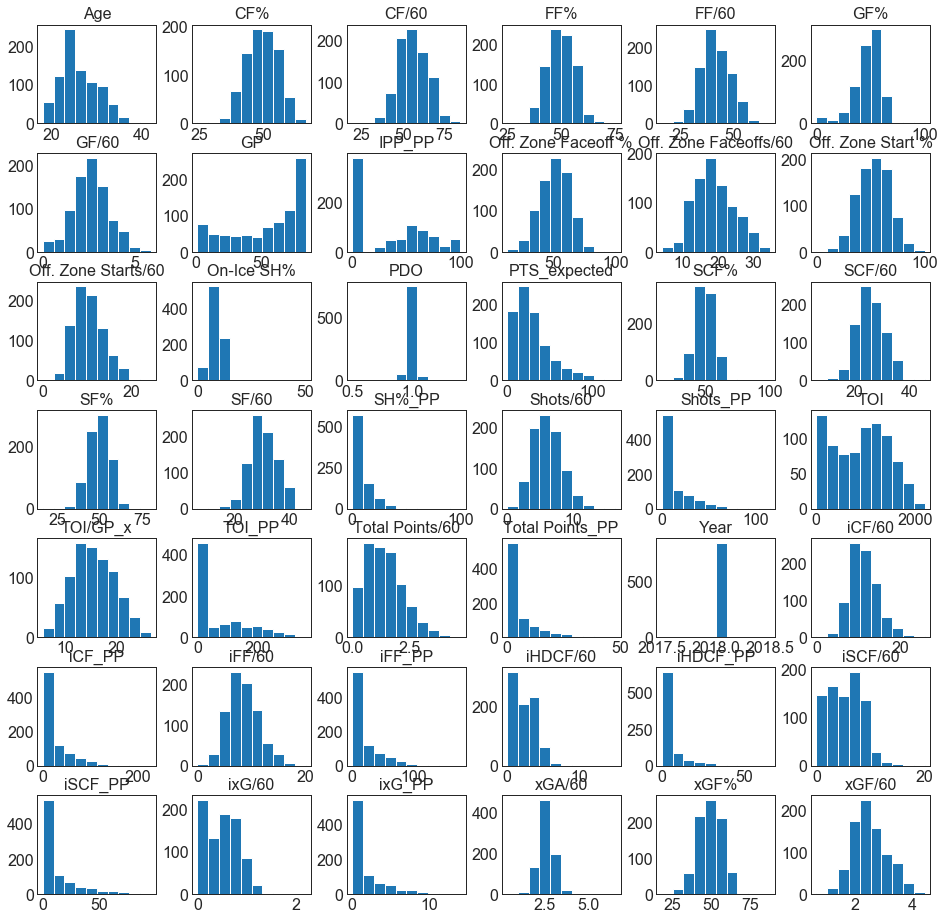

In [68]:
# Print histograms for each feature to see how they vary.
histograms = nhl_players_features.hist(grid=False, figsize=(16, 16))

## Feature engineering

In [69]:
# Feature Extractor
print('Extract features...')
from tsfresh.feature_extraction import *
features_filtered_direct = tsfresh.extract_features(nhl_players_features, 
                                                    column_id='Player', 
                                                    column_sort='Year',
                                                    default_fc_parameters=tsfresh.feature_extraction.settings.MinimalFCParameters())
 
# Convert NaN and inf
print('Impute NaN and Inf, remove zeros columns...')
features_filtered_direct = tsfresh.utilities.dataframe_functions.impute(features_filtered_direct)

# Remove zeros columns
features_filtered_direct = features_filtered_direct.loc[:, (features_filtered_direct != 0).any(axis=0)]

# Remove columns with same values
cols = list(features_filtered_direct)
nunique = features_filtered_direct.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
features_filtered_direct = features_filtered_direct.drop(cols_to_drop, axis=1)
print('Done.')

# Select relevant features
features_filtered_direct = features_filtered_direct.drop(list(filter(re.compile(".*_length").match, features_filtered_direct.columns)), axis=1)
features_filtered_direct = features_filtered_direct.drop(list(filter(re.compile(".*_sum_values").match, features_filtered_direct.columns)), axis=1)
features_filtered_direct = features_filtered_direct.drop(list(filter(re.compile(".*_standard_deviation").match, features_filtered_direct.columns)), axis=1)
features_filtered_direct = features_filtered_direct.drop(list(filter(re.compile("Age*").match, features_filtered_direct.columns)), axis=1)
# tsfresh.select_features(features_filtered_direct, total_points[:8], ml_task='regression')

Extract features...


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]


Impute NaN and Inf, remove zeros columns...
Done.


In [70]:
# Add current age, draft position
features_filtered_direct['Age'] = nhl_players.groupby('Player').tail(1).Age.values
features_filtered_direct['Overall Draft Position'] = nhl_players.groupby('Player').tail(1)['Overall Draft Position'].values

# Add stats from last 5 years
year_by_year = nhl_players_features.groupby('Player').tail(5).pivot_table(index='Player', columns='Year', values=nhl_players_features.columns)
year_by_year.columns = ['_'.join(str(i) for i in col) for col in year_by_year.columns.values]
for yr in ['2007', '2008', '2009', '2010', '2011', '2012', '2013']:
    year_by_year = year_by_year.drop(list(filter(re.compile(f".*_{yr}").match, year_by_year.columns)), axis=1)
features_filtered_direct = pd.concat([features_filtered_direct, year_by_year], axis=1)
features_filtered_direct['Position'] = nhl_players.groupby('Player').tail(1).Position.values
features_filtered_direct['Team'] = nhl_players.groupby('Player').tail(1).Team.values

# Add Position and convert to categorical (1 is Defense and 0 is offense)
# features_filtered_direct['Position'] = nhl_players.groupby('Player').tail(1).Position.values
# features_filtered_direct = pd.concat([features_filtered_direct, pd.get_dummies(features_filtered_direct['Position'])], axis=1)
# features_filtered_direct = features_filtered_direct.drop(['Position'], axis=1)
# features_filtered_direct['Position'] = (features_filtered_direct['D'] == 1).astype(int)
# features_filtered_direct = features_filtered_direct.drop(['C', 'C, L', 'C, R', 'D', 'L', 'L, R', 'R'], axis=1)

In [71]:
def normalizeFeature(feature):
    #Normalized Data
    return (feature-min(feature))/(max(feature)-min(feature))

In [72]:
# def getPlayerScore(player):
#     name = player.name
#     return normalizeFeature(features_filtered_direct['CF%__mean'])[name] + normalizeFeature(features_filtered_direct['FF%__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['GF%__mean'])[name] + normalizeFeature(features_filtered_direct['GP__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['Off. Zone Faceoff %__mean'])[name] + normalizeFeature(features_filtered_direct['Off. Zone Start %__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['On-Ice SH%__mean'])[name] - normalizeFeature(features_filtered_direct['PDO__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['PTS_expected__mean'])[name] + normalizeFeature(features_filtered_direct['SCF%__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['SF%__mean'])[name] + normalizeFeature(features_filtered_direct['SH%__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['Shots__mean'])[name] + normalizeFeature(features_filtered_direct['TOI__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['PTS_expected-1'])[name]
def getPlayerScore(player):
    name = player.name
    return normalizeFeature(features_filtered_direct['CF%__mean'])[name] + normalizeFeature(features_filtered_direct['FF%__mean'])[name] + \
            normalizeFeature(features_filtered_direct['GF%__mean'])[name] + normalizeFeature(features_filtered_direct['GP__mean'])[name] + \
            normalizeFeature(features_filtered_direct['Off. Zone Faceoff %__mean'])[name] + normalizeFeature(features_filtered_direct['Off. Zone Start %__mean'])[name] + \
            normalizeFeature(features_filtered_direct['On-Ice SH%__mean'])[name] - normalizeFeature(features_filtered_direct['PDO__mean'])[name] + \
            normalizeFeature(features_filtered_direct['PTS_expected__mean'])[name] + normalizeFeature(features_filtered_direct['SCF%__mean'])[name] + \
            normalizeFeature(features_filtered_direct['SF%__mean'])[name] + \
            normalizeFeature(features_filtered_direct['Shots/60__mean'])[name] + normalizeFeature(features_filtered_direct['TOI__mean'])[name]

In [73]:
# Get player score
features_filtered_direct['Score'] = features_filtered_direct.apply(lambda player: getPlayerScore(player), axis=1)

# Saving feature names for later use
feature_list = list(features_filtered_direct.columns)
features_filtered_direct.sort_values('Score', ascending=False).head(10)

,CF%__maximum,CF%__mean,CF%__median,CF%__minimum,CF/60__maximum,CF/60__mean,CF/60__median,CF/60__minimum,FF%__maximum,FF%__mean,FF%__median,FF%__minimum,FF/60__maximum,FF/60__mean,FF/60__median,FF/60__minimum,GF%__maximum,GF%__mean,GF%__median,GF%__minimum,GF/60__maximum,GF/60__mean,GF/60__median,GF/60__minimum,GP__maximum,GP__mean,GP__median,GP__minimum,IPP_PP__maximum,IPP_PP__mean,IPP_PP__median,IPP_PP__minimum,Off. Zone Faceoff %__maximum,Off. Zone Faceoff %__mean,Off. Zone Faceoff %__median,Off. Zone Faceoff %__minimum,Off. Zone Faceoffs/60__maximum,Off. Zone Faceoffs/60__mean,Off. Zone Faceoffs/60__median,Off. Zone Faceoffs/60__minimum,Off. Zone Start %__maximum,Off. Zone Start %__mean,Off. Zone Start %__median,Off. Zone Start %__minimum,Off. Zone Starts/60__maximum,Off. Zone Starts/60__mean,Off. Zone Starts/60__median,Off. Zone Starts/60__minimum,On-Ice SH%__maximum,On-Ice SH%__mean,On-Ice SH%__median,On-Ice SH%__minimum,PDO__maximum,PDO__mean,PDO__median,PDO__minimum,PTS_expected__maximum,PTS_expected__mean,PTS_expected__median,PTS_expected__minimum,SCF%__maximum,SCF%__mean,SCF%__median,SCF%__minimum,SCF/60__maximum,SCF/60__mean,SCF/60__median,SCF/60__minimum,SF%__maximum,SF%__mean,SF%__median,SF%__minimum,SF/60__maximum,SF/60__mean,SF/60__median,SF/60__minimum,SH%_PP__maximum,SH%_PP__mean,SH%_PP__median,SH%_PP__minimum,Shots/60__maximum,Shots/60__mean,Shots/60__median,Shots/60__minimum,Shots_PP__maximum,Shots_PP__mean,Shots_PP__median,Shots_PP__minimum,TOI/GP_x__maximum,TOI/GP_x__mean,TOI/GP_x__median,TOI/GP_x__minimum,TOI_PP__maximum,TOI_PP__mean,TOI_PP__median,TOI_PP__minimum,TOI__maximum,TOI__mean,TOI__median,TOI__minimum,Total Points/60__maximum,Total Points/60__mean,Total Points/60__median,Total Points/60__minimum,Total Points_PP__maximum,Total Points_PP__mean,Total Points_PP__median,Total Points_PP__minimum,iCF/60__maximum,iCF/60__mean,iCF/60__median,iCF/60__minimum,iCF_PP__maximum,iCF_PP__mean,iCF_PP__median,iCF_PP__minimum,iFF/60__maximum,iFF/60__mean,iFF/60__median,iFF/60__minimum,iFF_PP__maximum,iFF_PP__mean,iFF_PP__median,iFF_PP__minimum,iHDCF/60__maximum,iHDCF/60__mean,iHDCF/60__median,iHDCF/60__minimum,iHDCF_PP__maximum,iHDCF_PP__mean,iHDCF_PP__median,iHDCF_PP__minimum,iSCF/60__maximum,iSCF/60__mean,iSCF/60__median,iSCF/60__minimum,iSCF_PP__maximum,iSCF_PP__mean,iSCF_PP__median,iSCF_PP__minimum,ixG/60__maximum,ixG/60__mean,ixG/60__median,ixG/60__minimum,ixG_PP__maximum,ixG_PP__mean,ixG_PP__median,ixG_PP__minimum,xGA/60__maximum,xGA/60__mean,xGA/60__median,xGA/60__minimum,xGF%__maximum,xGF%__mean,xGF%__median,xGF%__minimum,xGF/60__maximum,xGF/60__mean,xGF/60__median,xGF/60__minimum,Age,Overall Draft Position,Age_2018,CF%_2018,CF/60_2018,FF%_2018,FF/60_2018,GF%_2018,GF/60_2018,GP_2018,IPP_PP_2018,Off. Zone Faceoff %_2018,Off. Zone Faceoffs/60_2018,Off. Zone Start %_2018,Off. Zone Starts/60_2018,On-Ice SH%_2018,PDO_2018,PTS_expected_2018,SCF%_2018,SCF/60_2018,SF%_2018,SF/60_2018,SH%_PP_2018,Shots/60_2018,Shots_PP_2018,TOI_2018,TOI/GP_x_2018,TOI_PP_2018,Total Points/60_2018,Total Points_PP_2018,iCF/60_2018,iCF_PP_2018,iFF/60_2018,iFF_PP_2018,iHDCF/60_2018,iHDCF_PP_2018,iSCF/60_2018,iSCF_PP_2018,ixG/60_2018,ixG_PP_2018,xGA/60_2018,xGF%_2018,xGF/60_2018,Position,Team,Score
Nathan MacKinnon,58.86,58.86,58.86,58.86,70.05,70.05,70.05,70.05,58.27,58.27,58.27,58.27,52.37,52.37,52.37,52.37,66.20,66.20,66.20,66.20,4.67,4.67,4.67,4.67,82.0,82.0,82.0,82.0,72.55,72.55,72.55,72.55,70.11,70.11,70.11,70.11,33.95,33.95,33.95,33.95,71.94,71.94,71.94,71.94,16.56,16.56,16.56,16.56,11.71,11.71,11.71,11.71,1.032,1.032,1.032,1.032,99.0,99.0,99.0,99.0,59.22,59.22,59.22,59.22,34.05,34.05,34.05,34.05,58.82,58.82,58.82,58.82,39.88,39.88,39.88,39.88,11.01,11.01,11.01,11.01,12.09,12.09,12.09,12.09,109.0,109.0,109.0,109.0,22.091463,22.091463,22.091463,22.091463,334.083333,334.083333,334.083333,334.083333,1811.500000,1811.500000,1811.500000,1811.500000,3.28,3.28,3.28,3.28,37.0,37.0,37.0,37.0,19.51,19.51,19.51,19.51,178.0,178.0,178.0,178.0,

## Name Standardization

In [74]:
features_filtered_direct['Name'] = features_filtered_direct.apply(lambda player: re.sub(r'\W+', '', f'{player.name}').upper(), axis=1)
nhl = features_filtered_direct.copy()
nhl = nhl.set_index('Name')
nhl = nhl.rename({'BURMISTROVALEX': 'BURMISTROVALEXANDER',
                                       'BURROWSALEX': 'BURROWSALEXANDRE',
                                       'CAMMALLERIMIKE': 'CAMMALLERIMICHAEL',
                                       'DEANGELOTONY': 'DEANGELOANTHONY',
                                       'DIDOMENICOCHRIS': 'DIDOMENICOCHRISTOPHER',
                                       'EDLERALEX': 'EDLERALEXANDER',
                                       'ENSTROMTOBY': 'ENSTROMTOBIAS',
                                       'FERLANDMICHEAL': 'FERLANDMICHAEL',
                                       'HINOSTROZAVINNIE': 'HINOSTROZAVINCENT',
                                       'KULEMINNIKOLAY': 'KULEMINNIKOLAI',
                                       'MARCHESSAULTJONATHAN': 'AUDYMARCHESSAULTJONATHAN',
                                       'MATHESONMIKE': 'MATHESONMICHAEL',
                                       'MORRISSEYJOSH': 'MORRISSEYJOSHUA',
                                       'PETROVICALEX': 'PETROVICALEXANDER',
                                       'RADULOVALEX': 'RADULOVALEXANDER',
                                       'WENNBERGALEX': 'WENNBERGALEXANDER'})
nhl.head(10)

,CF%__maximum,CF%__mean,CF%__median,CF%__minimum,CF/60__maximum,CF/60__mean,CF/60__median,CF/60__minimum,FF%__maximum,FF%__mean,FF%__median,FF%__minimum,FF/60__maximum,FF/60__mean,FF/60__median,FF/60__minimum,GF%__maximum,GF%__mean,GF%__median,GF%__minimum,GF/60__maximum,GF/60__mean,GF/60__median,GF/60__minimum,GP__maximum,GP__mean,GP__median,GP__minimum,IPP_PP__maximum,IPP_PP__mean,IPP_PP__median,IPP_PP__minimum,Off. Zone Faceoff %__maximum,Off. Zone Faceoff %__mean,Off. Zone Faceoff %__median,Off. Zone Faceoff %__minimum,Off. Zone Faceoffs/60__maximum,Off. Zone Faceoffs/60__mean,Off. Zone Faceoffs/60__median,Off. Zone Faceoffs/60__minimum,Off. Zone Start %__maximum,Off. Zone Start %__mean,Off. Zone Start %__median,Off. Zone Start %__minimum,Off. Zone Starts/60__maximum,Off. Zone Starts/60__mean,Off. Zone Starts/60__median,Off. Zone Starts/60__minimum,On-Ice SH%__maximum,On-Ice SH%__mean,On-Ice SH%__median,On-Ice SH%__minimum,PDO__maximum,PDO__mean,PDO__median,PDO__minimum,PTS_expected__maximum,PTS_expected__mean,PTS_expected__median,PTS_expected__minimum,SCF%__maximum,SCF%__mean,SCF%__median,SCF%__minimum,SCF/60__maximum,SCF/60__mean,SCF/60__median,SCF/60__minimum,SF%__maximum,SF%__mean,SF%__median,SF%__minimum,SF/60__maximum,SF/60__mean,SF/60__median,SF/60__minimum,SH%_PP__maximum,SH%_PP__mean,SH%_PP__median,SH%_PP__minimum,Shots/60__maximum,Shots/60__mean,Shots/60__median,Shots/60__minimum,Shots_PP__maximum,Shots_PP__mean,Shots_PP__median,Shots_PP__minimum,TOI/GP_x__maximum,TOI/GP_x__mean,TOI/GP_x__median,TOI/GP_x__minimum,TOI_PP__maximum,TOI_PP__mean,TOI_PP__median,TOI_PP__minimum,TOI__maximum,TOI__mean,TOI__median,TOI__minimum,Total Points/60__maximum,Total Points/60__mean,Total Points/60__median,Total Points/60__minimum,Total Points_PP__maximum,Total Points_PP__mean,Total Points_PP__median,Total Points_PP__minimum,iCF/60__maximum,iCF/60__mean,iCF/60__median,iCF/60__minimum,iCF_PP__maximum,iCF_PP__mean,iCF_PP__median,iCF_PP__minimum,iFF/60__maximum,iFF/60__mean,iFF/60__median,iFF/60__minimum,iFF_PP__maximum,iFF_PP__mean,iFF_PP__median,iFF_PP__minimum,iHDCF/60__maximum,iHDCF/60__mean,iHDCF/60__median,iHDCF/60__minimum,iHDCF_PP__maximum,iHDCF_PP__mean,iHDCF_PP__median,iHDCF_PP__minimum,iSCF/60__maximum,iSCF/60__mean,iSCF/60__median,iSCF/60__minimum,iSCF_PP__maximum,iSCF_PP__mean,iSCF_PP__median,iSCF_PP__minimum,ixG/60__maximum,ixG/60__mean,ixG/60__median,ixG/60__minimum,ixG_PP__maximum,ixG_PP__mean,ixG_PP__median,ixG_PP__minimum,xGA/60__maximum,xGA/60__mean,xGA/60__median,xGA/60__minimum,xGF%__maximum,xGF%__mean,xGF%__median,xGF%__minimum,xGF/60__maximum,xGF/60__mean,xGF/60__median,xGF/60__minimum,Age,Overall Draft Position,Age_2018,CF%_2018,CF/60_2018,FF%_2018,FF/60_2018,GF%_2018,GF/60_2018,GP_2018,IPP_PP_2018,Off. Zone Faceoff %_2018,Off. Zone Faceoffs/60_2018,Off. Zone Start %_2018,Off. Zone Starts/60_2018,On-Ice SH%_2018,PDO_2018,PTS_expected_2018,SCF%_2018,SCF/60_2018,SF%_2018,SF/60_2018,SH%_PP_2018,Shots/60_2018,Shots_PP_2018,TOI_2018,TOI/GP_x_2018,TOI_PP_2018,Total Points/60_2018,Total Points_PP_2018,iCF/60_2018,iCF_PP_2018,iFF/60_2018,iFF_PP_2018,iHDCF/60_2018,iHDCF_PP_2018,iSCF/60_2018,iSCF_PP_2018,ixG/60_2018,ixG_PP_2018,xGA/60_2018,xGF%_2018,xGF/60_2018,Position,Team,Score
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AARONEKBLAD,49.43,49.43,49.43,49.43,56.17,56.17,56.17,56.17,50.02,50.02,50.02,50.02,44.13,44.13,44.13,44.13,48.71,48.71,48.71,48.71,3.50,3.50,3.50,3.50,82.0,82.0,82.0,82.0,58.82,58.82,58.82,58.82,43.94,43.94,43.94,43.94,19.40,19.40,19.40,19.40,40.09,40.09,40.09,40.09,8.39,8.39,8.39,8.39,10.41,10.41,10.41,10.41,0.985,0.985,0.985,0.985,37.0,37.0,37.0,37.0,47.88,47.88,47.88,47.88,25.53,25.53,25.53,25.53,51.99,51.99,51.99,51.99,33.58,33.58,33.58,33.58,13.51,13.51,13.51,13.51,5.57,5.57,5.57,5.57,37.0,37.0,37.0,37.0,23.644106,23.644106,23.644

---
## Contracts

In order to get contract end. Exports from google drive pool spreadsheet.

### Forwards

In [75]:
nhl_att_contracts = pd.read_csv('../data/Pool-Att-1819.csv', header=1, encoding = "utf-8")
nhl_att_contracts = nhl_att_contracts.rename(columns={'Unnamed: 95': "Cap Hit_18", 'Unnamed: 96': "END", "Unnamed: 0": "Name"})
nhl_att_contracts['Name'] = nhl_att_contracts.apply(lambda player: re.sub(r'\W+', '', f'{player["Unnamed: 3"]}{player["Unnamed: 2"]}').upper(), axis=1)
nhl_att_contracts.set_index('Name', inplace=True)
nhl_att_contracts.rename({'BURMISTROVALEX': 'BURMISTROVALEXANDER',
           'BURROWSALEX': 'BURROWSALEXANDRE',
           'CAMMALLERIMIKE': 'CAMMALLERIMICHAEL',
           'DEANGELOTONY': 'DEANGELOANTHONY',
           'DIDOMENICOCHRIS': 'DIDOMENICOCHRISTOPHER',
           'EDLERALEX': 'EDLERALEXANDER',
           'ENSTROMTOBY': 'ENSTROMTOBIAS',
           'FERLANDMICHEAL': 'FERLANDMICHAEL',
           'HINOSTROZAVINNIE': 'HINOSTROZAVINCENT',
           'KULEMINNIKOLAY': 'KULEMINNIKOLAI',
           'MARCHESSAULTJONATHAN': 'AUDYMARCHESSAULTJONATHAN',
           'MATHESONMIKE': 'MATHESONMICHAEL',
           'MORRISSEYJOSH': 'MORRISSEYJOSHUA',
           'PETROVICALEX': 'PETROVICALEXANDER',
           'RADULOVALEX': 'RADULOVALEXANDER',
           'WENNBERGALEX': 'WENNBERGALEXANDER'}, inplace = True)
nhl_att_contracts.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Position,GP_13,GP_14,GP_15,GP_16,GP_17,Real,Mean,Var,G_13,G_14,G_15,G_16,G_17,G_18,A_13,A_14,A_15,A_16,A_17,A_18,PTS_13,PTS_14,PTS_15,PTS_16,PTS_17,Proj,Chuck Lemieux,NHL,ESPN,Fantrax,TSN,Real.1,Mean.1,Var.1,PAX,PTS/G_13,PTS/G_14,PTS/G_15,PTS/G_16,PTS/G_17,Real.2,Mean.2,Var.2,$/PTS_13,$/PTS_14,$/PTS_15,$/PTS_16,$/PTS_17,Unnamed: 56,Sh%_13,Sh%_14,Sh%_15,Sh%_16,Sh%_17,iSF_13,iSF_14,iSF_15,iSF_16,iSF_17,iSF,TOI/G_13,TOI/G_14,TOI/G_15,TOI/G_16,TOI/G_17,5v5,PPTOI/GP_17,PP,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Cap Hit_18,END,Unnamed: 97,Unnamed: 98,Unnamed: 99
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CONNORMCDAVID,McDavid Connor,McDavid,Connor,X,EDM,22.0,C,NaN,NaN,NaN,45.0,82.0,82.0,70.0,304.0,NaN,NaN,NaN,16.0,30.0,41.0,NaN,NaN,NaN,32.0,70.0,67.0,NaN,NaN,NaN,48.0,100.0,108.0,112.0,105.0,111.0,105.0,108.0,108.0,85.0,708.0,12.0,NaN,NaN,NaN,1.066667,1.219512,1.32,1.20,0.011,NaN,NaN,NaN,10575.45732,9250.00000,"115,527",NaN,NaN,NaN,0.152,0.124,NaN,NaN,NaN,105.0,252.0,275.0,NaN,NaN,NaN,18.9,21.13,21.55,2.87,2.97,10.4%,61%,40.6,1184.0,1.32,7.86,10.5,1032,1004.0,421.0,434.0,329.0,357.0,NaN,NaN,NaN,925000.0,925000.0,925000.0,"12,500,000",26.0,18.14,9.70,NaN
NIKITAKUCHEROV,Kucherov Nikita,Kucherov,Nikita,X,TBL,25.0,RW,NaN,52.0,82.0,77.0,74.0,80.0,73.0,118.0,NaN,9.0,29.0,30.0,40.0,39.0,NaN,9.0,36.0,36.0,45.0,61.0,NaN,18.0,65.0,66.0,85.0,97.0,106.0,95.0,94.0,97.0,92.0,100.0,67.0,764.0,34.0,NaN,0.346154,0.792683,0.857143,1.148649,1.25,0.88,0.100,NaN,31501.81843,13676.92308,10130.08130,50607.36844,"49,242",NaN,0.088,0.152,0.144,0.120,NaN,102.0,191.0,209.0,246.0,279.0,NaN,13.1,15.0,18.2,19.43,19.82,3.20,3.51,11.9%,71%,37.4,1036.0,1.27,5.29,9.8,1032,1035.0,464.0,546.0,348.0,422.0,NaN,894167.0,889000.0,712000.0,4766667.0,4766667.0,"4,766,667",19.0,14.50,9.18,NaN
SIDNEYCROSBY,Crosby Sidney,Crosby,Sidney,X,PIT,31.0,C,36.0,80.0,77.0,80.0,75.0,82.0,79.0,6.0,15.0,36.0,28.0,36.0,44.0,29.0,41.0,68.0,56.0,49.0,45.0,60.0,56.0,104.0,84.0,85.0,89.0,91.0,90.0,92.0,88.0,90.0,94.0,89.0,90.0,52.0,-19.0,1.555556,1.300000,1.090909,1.062500,1.186667,1.09,1.21,0.030,68205.57491,81613.50844,97256.09756,99856.52798,89408.05700,"95,815",0.121,0.139,0.118,0.145,0.114,124.0,259.0,237.0,248.0,255.0,247.0,21.1,22.0,20.0,20.5,19.88,20.69,3.47,3.65,10.8%,66%,32.1,1215.0,1.14,3.09,7.3,1031,1008.0,411.0,412.0,325.0,341.0,8700000.0,8700000.0,8700000.0,8700000.0,8700000.0,8700000.0,"8,700,000",25.0,12.68,9.43,NaN
NATHANMACKINNON,MacKinnon Nathan,MacKinnon,Nathan,X,COL,23.0,C,NaN,82.0,64.0,72.0,82.0,74.0,75.0,46.0,NaN,24.0,14.0,21.0,16.0,39.0,NaN,39.0,24.0,31.0,37.0,58.0,NaN,63.0,38.0,52.0,53.0,90.0,95.0,90.0,89.0,86.0,88.0,97.0,61.0,395.0,46.0,NaN,0.768293,0.593750,0.722222,0.646341,1.31,0.81,0.067,NaN,59920.63492,77535.30167,15619.13696,118867.92450,"70,313",NaN,0.100,0.073,0.086,0.088,NaN,241.0,192.0,245.0,252.0,284.0,NaN,17.3,17.0,18.9,19.95,19.91,2.63,3.61,13.8%,65%,37.0,885.0,1.25,5.08,10.0,981,1039.0,436.0,496.0,333.0,393.0,NaN,3775000.0,3775000.0,925000.0,6300000.0,6300000.0,"6,300,000",23.0,17.20,9.08,NaN
JOHNNYGAUDREAU,Gaudreau Johnny,Gaudreau,Johnny,X,CGY,25.0,LW,NaN,1.0,80.0,79.0,72.0,80.0,62.0,951.0,NaN,1.0,24.0,30.0,18.0,24.0,NaN,0.0,40.0,48.0,43.0,60.0,NaN,1.0,64.0,78.0,61.0,86.0,88.0,86.0,85.0,88.0,81.0,84.0,58.0,874.0,14.0,NaN,1.000000,0.800000,0.987342,0.847222,1.05,0.94,0.009,NaN,22560.97561,28201.21951,11425.10944,97161.13555,"78,855",NaN,1.000,0.144,0.138,0.097,NaN,1.0,167.0,217.0,182.0,227.0,NaN,15.2,17.7,19.9,18.48,19.42,3.09,3.54,10.4%,69%,29.4,1092.0,1.10,1.14,6.7,1006,999.0,307.0,407.0,241.0,316.0,NaN,1850000.0,1850000.0,925000.0,6750000.0,6750000.0,"6,750,000",22.0,8.42,7.27,NaN


### Defensemen

In [76]:
nhl_def_contracts = pd.read_csv('../data/Pool-Def-1819.csv', header=1, encoding = "utf-8")
nhl_def_contracts = nhl_def_contracts.rename(columns={'Unnamed: 95': "Cap Hit_18", 'Unnamed: 96': "END", "Unnamed: 0": "Name"})
nhl_def_contracts['Name'] = nhl_def_contracts.apply(lambda player: re.sub(r'\W+', '', f'{player["Unnamed: 3"]}{player["Unnamed: 2"]}').upper(), axis=1)
nhl_def_contracts.set_index('Name', inplace=True)
nhl_def_contracts.rename({'BURMISTROVALEX': 'BURMISTROVALEXANDER',
           'BURROWSALEX': 'BURROWSALEXANDRE',
           'CAMMALLERIMIKE': 'CAMMALLERIMICHAEL',
           'DEANGELOTONY': 'DEANGELOANTHONY',
           'DIDOMENICOCHRIS': 'DIDOMENICOCHRISTOPHER',
           'EDLERALEX': 'EDLERALEXANDER',
           'ENSTROMTOBY': 'ENSTROMTOBIAS',
           'FERLANDMICHEAL': 'FERLANDMICHAEL',
           'HINOSTROZAVINNIE': 'HINOSTROZAVINCENT',
           'KULEMINNIKOLAY': 'KULEMINNIKOLAI',
           'MARCHESSAULTJONATHAN': 'AUDYMARCHESSAULTJONATHAN',
           'MATHESONMIKE': 'MATHESONMICHAEL',
           'MORRISSEYJOSH': 'MORRISSEYJOSHUA',
           'PETROVICALEX': 'PETROVICALEXANDER',
           'RADULOVALEX': 'RADULOVALEXANDER',
           'WENNBERGALEX': 'WENNBERGALEXANDER'}, inplace = True)
nhl_def_contracts.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Position,GP_13,GP_14,GP_15,GP_16,GP_17,Real,Mean,Var,G_13,G_14,G_15,G_16,G_17,G_18,A_13,A_14,A_15,A_16,A_17,A_18,PTS_13,PTS_14,PTS_15,PTS_16,PTS_17,Proj,Chuck Lemieux,NHL,ESPN,Fantrax,TSN,Real.1,Mean.1,Var.1,PAX,PTS/G_13,PTS/G_14,PTS/G_15,PTS/G_16,PTS/G_17,Real.2,Mean.2,Var.2,$/PTS_13,$/PTS_14,$/PTS_15,$/PTS_16,$/PTS_17,Unnamed: 56,Sh%_13,Sh%_14,Sh%_15,Sh%_16,Sh%_17,iSF_13,iSF_14,iSF_15,iSF_16,iSF_17,iSF,TOI/G_13,TOI/G_14,TOI/G_15,TOI/G_16,TOI/G_17,5v5,PPTOI/GP_17,PP,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Cap Hit_18,END,Unnamed: 97,Unnamed: 98,Unnamed: 99
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BRENTBURNS,Burns Brent,Burns,Brent,X,SJS,33.0,D,30.0,69.0,82.0,82.0,82.0,82.0,79.0,27.0,9.0,22.0,17.0,27.0,29.0,12.0,11.0,26.0,43.0,48.0,47.0,55.0,20.0,48.0,60.0,75.0,76.0,70.0,70.0,71.0,75.0,64.0,71.0,67.0,65.0,108.0,20.0,0.666667,0.695652,0.731707,0.914634,0.926829,0.82,0.79,0.010,105365.8537,100975.60980,96000.000000,76800.00000,75789.47368,"113,960",0.111,0.090,0.069,0.076,0.099,81.0,245.0,245.0,353.0,322.0,332.0,16.3,16.8,24.0,25.9,24.93,25.24,3.36,3.68,8.5%,67%,21.6,1245.0,1.02,0.39,5.4,1019.0,1006.0,777.0,774.0,483.0,481.0,5760000.0,5760000.0,5760000.0,5760000.0,5760000.0,8000000.0,"8,000,000",25.0,6.49,8.96,NaN
ERIKKARLSSON,Karlsson Erik,Karlsson,Erik,X,OTT,28.0,D,17.0,82.0,82.0,82.0,77.0,71.0,79.0,19.0,6.0,20.0,21.0,16.0,17.0,9.0,8.0,54.0,45.0,66.0,54.0,53.0,14.0,74.0,66.0,82.0,71.0,68.0,69.0,72.0,73.0,58.0,70.0,62.0,71.0,47.0,4.0,0.823529,0.902439,0.804878,1.000000,0.922078,0.87,0.89,0.004,96254.3554,87837.83784,98484.848480,79268.29268,85967.02164,"95,029",0.076,0.078,0.072,0.065,0.095,79.0,257.0,292.0,248.0,218.0,196.0,27.2,27.1,27.3,29.0,26.83,26.74,3.55,3.32,9.2%,61%,20.1,951.0,0.85,0.86,4.9,1013.0,1033.0,506.0,477.0,337.0,296.0,6500000.0,6500000.0,6500000.0,6500000.0,6500000.0,6500000.0,"6,500,000",19.0,6.36,7.96,NaN
VICTORHEDMAN,Hedman Victor,Hedman,Victor,X,TBL,28.0,D,44.0,75.0,59.0,78.0,79.0,77.0,74.0,55.0,4.0,13.0,10.0,10.0,16.0,17.0,16.0,42.0,28.0,37.0,56.0,46.0,20.0,55.0,38.0,47.0,72.0,65.0,68.0,68.0,66.0,62.0,62.0,63.0,55.0,141.0,21.0,0.454545,0.733333,0.644068,0.602564,0.911392,0.82,0.69,0.022,107317.0732,66518.84701,75738.125800,80954.85210,53523.03523,"120,782",0.053,0.076,0.087,0.056,0.118,76.0,170.0,115.0,180.0,166.0,216.0,22.7,22.4,22.7,23.1,24.50,25.85,2.95,3.40,11.6%,54%,22.0,1067.0,0.93,0.04,5.7,1031.0,971.0,408.0,469.0,270.0,312.0,4000000.0,4000000.0,4000000.0,4000000.0,4000000.0,7875000.0,"7,875,000",25.0,6.64,7.54,NaN
JOHNKLINGBERG,Klingberg John,Klingberg,John,X,DAL,26.0,D,NaN,NaN,65.0,76.0,80.0,82.0,76.0,43.0,NaN,NaN,11.0,10.0,13.0,8.0,NaN,NaN,29.0,48.0,36.0,59.0,NaN,NaN,40.0,58.0,49.0,63.0,71.0,66.0,63.0,54.0,61.0,67.0,54.0,101.0,13.0,NaN,NaN,0.615385,0.763158,0.612500,0.82,0.70,0.008,NaN,NaN,14268.292680,67914.21362,84619.21354,"67,460",NaN,NaN,0.112,0.058,0.106,NaN,NaN,98.0,171.0,124.0,204.0,NaN,NaN,21.8,22.7,23.35,24.07,3.03,3.65,10.2%,62%,22.1,1226.0,0.91,1.66,5.4,1016.0,983.0,313.0,455.0,194.0,286.0,NaN,NaN,720000.0,4250000.0,4250000.0,4250000.0,"4,250,000",22.0,5.82,8.00,NaN
SHAYNEGOSTISBEHERE,Gostisbehere Shayne,Gostisbehere,Shayne,X,PHI,25.0,D,NaN,NaN,2.0,64.0,76.0,78.0,55.0,965.0,NaN,NaN,0.0,17.0,7.0,13.0,NaN,NaN,0.0,29.0,32.0,52.0,NaN,NaN,0.0,46.0,39.0,61.0,67.0,57.0,69.0,57.0,56.0,65.0,38.0,559.0,18.0,NaN,NaN,0.000000,0.718750,0.513158,0.83,0.52,0.102,NaN,NaN,1292.682927,15694.59173,21982.48906,"73,529",NaN,NaN,0.000,0.112,0.082,NaN,NaN,2.0,152.0,198.0,221.0,NaN,NaN,12.6,20.1,19.58,21.46,3.65,3.61,11.3%,68%,21.1,972.0,0.90,0.11,5.8,992.0,975.0,445.0,458.0,303.0,320.0,NaN,NaN,53000.0,925000.0,925000.0,4500000.0,"4,500,000",23.0,4.85,6.25,NaN


### All

In [77]:
nhl_contracts = pd.concat([nhl_att_contracts, nhl_def_contracts], sort=True)
nhl = nhl.join(nhl_contracts[['Unnamed: 2', 'Unnamed: 3', 'END']])
nhl = nhl.rename({'Unnamed: 2': "Last Name", 'Unnamed: 3': 'First Name'}, axis=1)

## Salary Correction

Update with salaries from 2019-2020 season from https://www.hockey-reference.com/friv/current_nhl_salaries.cgi

In [79]:
# Salaries of 2019-2020 season
nhl_salaries = pd.read_csv('../data/Salaries-2019-2020.csv', header=None, sep=';', encoding = "utf-8")
nhl_salaries.columns = ['Player', 'Team', 'Salary', 'Cap_Hit']
nhl_salaries['Name'] = nhl_salaries.Player.apply(lambda player: re.sub(r'\W+', '', f'{player}').upper())
nhl_salaries.set_index('Name', inplace=True)
nhl_salaries.rename({'BURMISTROVALEX': 'BURMISTROVALEXANDER',
           'BURROWSALEX': 'BURROWSALEXANDRE',
           'CAMMALLERIMIKE': 'CAMMALLERIMICHAEL',
           'DEANGELOTONY': 'DEANGELOANTHONY',
           'DIDOMENICOCHRIS': 'DIDOMENICOCHRISTOPHER',
           'EDLERALEX': 'EDLERALEXANDER',
           'ENSTROMTOBY': 'ENSTROMTOBIAS',
           'FERLANDMICHEAL': 'FERLANDMICHAEL',
           'HINOSTROZAVINNIE': 'HINOSTROZAVINCENT',
           'KULEMINNIKOLAY': 'KULEMINNIKOLAI',
           'MARCHESSAULTJONATHAN': 'AUDYMARCHESSAULTJONATHAN',
           'MATHESONMIKE': 'MATHESONMICHAEL',
           'MORRISSEYJOSH': 'MORRISSEYJOSHUA',
           'PETROVICALEX': 'PETROVICALEXANDER',
           'RADULOVALEX': 'RADULOVALEXANDER',
           'WENNBERGALEX': 'WENNBERGALEXANDER'}, inplace = True)
nhl_salaries.head()

# Reverse index of df and join the salaries
nhl = nhl.join(nhl_salaries.Cap_Hit)

# Convert to float
nhl['Cap_Hit'] = nhl['Cap_Hit'].replace(',', '', regex=True).astype(float)

# If contract ended last year, put ending year to NaN and add manually
nhl.loc[nhl.END == 19, 'END'] = np.nan
nhl.head()

,Player,Team,Salary,Cap_Hit
Name,,,,
JOHNTAVARES,John Tavares,TOR,"15,900,000","11,000,000"
AUSTONMATTHEWS,Auston Matthews,TOR,"15,900,000","11,634,000"
CAREYPRICE,Carey Price,MTL,"15,000,000","10,500,000"
ERIKKARLSSON,Erik Karlsson,SJS,"14,500,000","11,500,000"
CONNORMCDAVID,Connor McDavid,EDM,"14,000,000","12,500,000"


,CF%__maximum,CF%__mean,CF%__median,CF%__minimum,CF/60__maximum,CF/60__mean,CF/60__median,CF/60__minimum,FF%__maximum,FF%__mean,FF%__median,FF%__minimum,FF/60__maximum,FF/60__mean,FF/60__median,FF/60__minimum,GF%__maximum,GF%__mean,GF%__median,GF%__minimum,GF/60__maximum,GF/60__mean,GF/60__median,GF/60__minimum,GP__maximum,GP__mean,GP__median,GP__minimum,IPP_PP__maximum,IPP_PP__mean,IPP_PP__median,IPP_PP__minimum,Off. Zone Faceoff %__maximum,Off. Zone Faceoff %__mean,Off. Zone Faceoff %__median,Off. Zone Faceoff %__minimum,Off. Zone Faceoffs/60__maximum,Off. Zone Faceoffs/60__mean,Off. Zone Faceoffs/60__median,Off. Zone Faceoffs/60__minimum,Off. Zone Start %__maximum,Off. Zone Start %__mean,Off. Zone Start %__median,Off. Zone Start %__minimum,Off. Zone Starts/60__maximum,Off. Zone Starts/60__mean,Off. Zone Starts/60__median,Off. Zone Starts/60__minimum,On-Ice SH%__maximum,On-Ice SH%__mean,On-Ice SH%__median,On-Ice SH%__minimum,PDO__maximum,PDO__mean,PDO__median,PDO__minimum,PTS_expected__maximum,PTS_expected__mean,PTS_expected__median,PTS_expected__minimum,SCF%__maximum,SCF%__mean,SCF%__median,SCF%__minimum,SCF/60__maximum,SCF/60__mean,SCF/60__median,SCF/60__minimum,SF%__maximum,SF%__mean,SF%__median,SF%__minimum,SF/60__maximum,SF/60__mean,SF/60__median,SF/60__minimum,SH%_PP__maximum,SH%_PP__mean,SH%_PP__median,SH%_PP__minimum,Shots/60__maximum,Shots/60__mean,Shots/60__median,Shots/60__minimum,Shots_PP__maximum,Shots_PP__mean,Shots_PP__median,Shots_PP__minimum,TOI/GP_x__maximum,TOI/GP_x__mean,TOI/GP_x__median,TOI/GP_x__minimum,TOI_PP__maximum,TOI_PP__mean,TOI_PP__median,TOI_PP__minimum,TOI__maximum,TOI__mean,TOI__median,TOI__minimum,Total Points/60__maximum,Total Points/60__mean,Total Points/60__median,Total Points/60__minimum,Total Points_PP__maximum,Total Points_PP__mean,Total Points_PP__median,Total Points_PP__minimum,iCF/60__maximum,iCF/60__mean,iCF/60__median,iCF/60__minimum,iCF_PP__maximum,iCF_PP__mean,iCF_PP__median,iCF_PP__minimum,iFF/60__maximum,iFF/60__mean,iFF/60__median,iFF/60__minimum,iFF_PP__maximum,iFF_PP__mean,iFF_PP__median,iFF_PP__minimum,iHDCF/60__maximum,iHDCF/60__mean,iHDCF/60__median,iHDCF/60__minimum,iHDCF_PP__maximum,iHDCF_PP__mean,iHDCF_PP__median,iHDCF_PP__minimum,iSCF/60__maximum,iSCF/60__mean,iSCF/60__median,iSCF/60__minimum,iSCF_PP__maximum,iSCF_PP__mean,iSCF_PP__median,iSCF_PP__minimum,ixG/60__maximum,ixG/60__mean,ixG/60__median,ixG/60__minimum,ixG_PP__maximum,ixG_PP__mean,ixG_PP__median,ixG_PP__minimum,xGA/60__maximum,xGA/60__mean,xGA/60__median,xGA/60__minimum,xGF%__maximum,xGF%__mean,xGF%__median,xGF%__minimum,xGF/60__maximum,xGF/60__mean,xGF/60__median,xGF/60__minimum,Age,Overall Draft Position,Age_2018,CF%_2018,CF/60_2018,FF%_2018,FF/60_2018,GF%_2018,GF/60_2018,GP_2018,IPP_PP_2018,Off. Zone Faceoff %_2018,Off. Zone Faceoffs/60_2018,Off. Zone Start %_2018,Off. Zone Starts/60_2018,On-Ice SH%_2018,PDO_2018,PTS_expected_2018,SCF%_2018,SCF/60_2018,SF%_2018,SF/60_2018,SH%_PP_2018,Shots/60_2018,Shots_PP_2018,TOI_2018,TOI/GP_x_2018,TOI_PP_2018,Total Points/60_2018,Total Points_PP_2018,iCF/60_2018,iCF_PP_2018,iFF/60_2018,iFF_PP_2018,iHDCF/60_2018,iHDCF_PP_2018,iSCF/60_2018,iSCF_PP_2018,ixG/60_2018,ixG_PP_2018,xGA/60_2018,xGF%_2018,xGF/60_2018,Position,Team,Score,Unnamed: 2,Unnamed: 3,END,Cap_Hit
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AARONEKBLAD,49.43,49.43,49.43,49.43,56.17,56.17,56.17,56.17,50.02,50.02,50.02,50.02,44.13,44.13,44.13,44.13,48.71,48.71,48.71,48.71,3.50,3.50,3.50,3.50,82.0,82.0,82.0,82.0,58.82,58.82,58.82,58.82,43.94,43.94,43.94,43.94,19.40,19.40,19.40,19.40,40.09,40.09,40.09,40.09,8.39,8.39,8.39,8.39,10.41,10.41,10.41,10.41,0.985,0.985,0.985,0.985,37.0,37.0,37.0,37.0,47.88,47.88,47.88,47.88,25.53,25.53,25.53,25.53,51.99,51.99,51.99,51.99,33.58,33.58,33.58,33.58,13.51,13.51,13.51,13.51,5.57,5.57,5.57,5.57,37.0,37.

In [87]:
# Filter to get only desired columns
nhl = nhl.filter(regex=("^GP|^Off. Zone Start %|^On-Ice SH%|^PDO|^PTS_expected|^TOI/GP_x|^TOI_PP|^Total Points/60|^Total Points_PP|First Name|Last Name|Age|Position|Team|Score|END|Cap_Hit"))
nhl['Team'] = nhl['Team'].apply(lambda tm: str(tm).split('/')[-1])
nhl = nhl[nhl.index != 'NANNAN']
nhl.head(10)

,GP__maximum,GP__mean,GP__median,GP__minimum,Off. Zone Start %__maximum,Off. Zone Start %__mean,Off. Zone Start %__median,Off. Zone Start %__minimum,On-Ice SH%__maximum,On-Ice SH%__mean,On-Ice SH%__median,On-Ice SH%__minimum,PDO__maximum,PDO__mean,PDO__median,PDO__minimum,PTS_expected__maximum,PTS_expected__mean,PTS_expected__median,PTS_expected__minimum,TOI/GP_x__maximum,TOI/GP_x__mean,TOI/GP_x__median,TOI/GP_x__minimum,TOI_PP__maximum,TOI_PP__mean,TOI_PP__median,TOI_PP__minimum,Total Points/60__maximum,Total Points/60__mean,Total Points/60__median,Total Points/60__minimum,Total Points_PP__maximum,Total Points_PP__mean,Total Points_PP__median,Total Points_PP__minimum,Age,Overall Draft Position,Age_2018,GP_2018,Off. Zone Start %_2018,On-Ice SH%_2018,PDO_2018,PTS_expected_2018,TOI/GP_x_2018,TOI_PP_2018,Total Points/60_2018,Total Points_PP_2018,Position,Team,Score,Last Name,First Name,END,Cap_Hit
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AARONEKBLAD,82.0,82.0,82.0,82.0,40.09,40.09,40.09,40.09,10.41,10.41,10.41,10.41,0.985,0.985,0.985,0.985,37.0,37.0,37.0,37.0,23.644106,23.644106,23.644106,23.644106,138.800000,138.800000,138.800000,138.800000,1.15,1.15,1.15,1.15,10.0,10.0,10.0,10.0,22,1,22,82,40.09,10.41,0.985,37.0,23.644106,138.800000,1.15,10,D,FLA,5.436150,Ekblad,Aaron,25.0,7500000.0
ADAMCLENDENING,4.0,4.0,4.0,4.0,60.00,60.00,60.00,60.00,10.53,10.53,10.53,10.53,1.043,1.043,1.043,1.043,0.0,0.0,0.0,0.0,10.654167,10.654167,10.654167,10.654167,1.150000,1.150000,1.150000,1.150000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,26,36,26,4,60.00,10.53,1.043,0.0,10.654167,1.150000,0.00,0,D,CBJ,2.596544,Clendening,Adam,NaN,700000.0
ADAMERNE,65.0,65.0,65.0,65.0,48.04,48.04,48.04,48.04,10.79,10.79,10.79,10.79,1.044,1.044,1.044,1.044,24.0,24.0,24.0,24.0,10.548205,10.548205,10.548205,10.548205,32.383333,32.383333,32.383333,32.383333,1.75,1.75,1.75,1.75,2.0,2.0,2.0,2.0,23,33,23,65,48.04,10.79,1.044,24.0,10.548205,32.383333,1.75,2,L,T.B,4.691995,Erne,Adam,NaN,NaN
ADAMGAUDETTE,56.0,56.0,56.0,56.0,77.60,77.60,77.60,77.60,8.03,8.03,8.03,8.03,0.999,0.999,0.999,0.999,16.0,16.0,16.0,16.0,10.949107,10.949107,10.949107,10.949107,76.633333,76.633333,76.633333,76.633333,1.17,1.17,1.17,1.17,2.0,2.0,2.0,2.0,22,149,22,56,77.60,8.03,0.999,16.0,10.949107,76.633333,1.17,2,C,VAN,4.882991,Gaudette,Adam,20.0,NaN
ADAMHENRIQUE,82.0,82.0,82.0,82.0,58.06,58.06,58.06,58.06,10.59,10.59,10.59,10.59,1.015,1.015,1.015,1.015,42.0,42.0,42.0,42.0,16.451220,16.451220,16.451220,16.451220,189.366667,189.366667,189.366667,189.366667,1.87,1.87,1.87,1.87,13.0,13.0,13.0,13.0,28,82,28,82,58.06,10.59,1.015,42.0,16.451220,189.366667,1.87,13,C,ANA,5.500572,Henrique,Adam,NaN,5825000.0
ADAMLARSSON,82.0,82.0,82.0,82.0,29.91,29.91,29.91,29.91,6.63,6.63,6.63,6.63,0.957,0.957,0.957,0.957,20.0,20.0,20.0,20.0,21.623171,21.623171,21.623171,21.623171,6.333333,6.333333,6.333333,6.333333,0.68,0.68,0.68,0.68,0.0,0.0,0.0,0.0,26,4,26,82,29.91,6.63,0.957,20.0,21.623171,6.333333,0.68,0,D,EDM,4.508587,Larsson,Adam,21.0,4166666.0
ADAMLOWRY,78.0,78.0,78.0,78.0,30.51,30.51,30.51,30.51,7.71,7.71,7.71,7.71,0.999,0.999,0.999,0.999,24.0,24.0,24.0,24.0,14.638248,14.638248,14.638248,14.638248,8.316667,8.316667,8.316667,8.316667,1.21,1.21,1.21,1.21,0.0,0.0,0.0,0.0,25,67,25,78,30.51,7.71,0.999,24.0,14.638248,8.316667,1.21,0,C,WPG,4.137025,Lowry,Adam,21.0,2916666.0
ADAMMCQUAID,50.0,50.0,50.0,50.0,35.83,35.83,35.83,35.83,9.97,9.97,9.97,9.97,1.012,1.012,1.012,1.012,10.0,10.0,10.0,10.0,15.777333,15.777333,15.777333,15.777333,0.566667,0.566667,0.566667,0.566667,0.53,0.53,0.53,0.53,0.0,0.0,0.0,0.0,32,55,32,50,35.83,9.97,1.012,10.0,15.777333,0.566667,0.53,0,D,"CBJ, NYR",3.242386,McQuaid,Adam,NaN,NaN
ADAMPELECH,78.0,78.0,78.0,78.0,36.68,36.68,36.68,36.68,9.22,9.22,9.22,9.22,1.019,1.019,1.019,1.019,22.0,22.0,22.0,22.0,18.629487,18.629487,18.629487,18.629487,11.233333,11.233333,11.233333,11.233333,0.87,0.87,0.87,0.87,0.0,0.0,0.0,0.0,24,65,24,78,36.68,9.22,1.019,22.0,18.629487,11.233333,0.87,0,D,NYI,4.583594,Pelech,A